In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import glob
import re
import pandas as pd
import seaborn as sns
import math
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from scipy.stats import ttest_ind
from io import StringIO
import os
import torch

RDKit WARNING: [15:51:23] Enabling RDKit 2020.03.1dev1 jupyter extensions


# Helper functions to be used throughout the analysis

In [3]:
def get_stats(pred, gold):
    rmse=np.sqrt(np.mean((pred-gold)**2))
    r2=np.corrcoef(pred,gold)[0][1]**2
    return(rmse,r2)

In [4]:
plt.rc('axes',labelsize=13)
plt.rc('axes',titlesize=13)

## Generating LaTeX for Table 1 and STable1

In [5]:
data=pd.read_csv('data/soltrannet_sweep_table.csv')

In [6]:
print(data.to_latex(columns=['Model','Parameters']+[x for x in data.columns.tolist() if 'RMSE' in x]))

\begin{tabular}{llrrrrrr}
\toprule
{} &    Model &  Parameters &  CCV RMSE &  Fold0 RMSE &  Fold1 RMSE &  Fold2 RMSE &  Ind RMSE \\
\midrule
0  &      MAT &    42049537 &     2.007 &       1.231 &       3.075 &       1.058 &     2.113 \\
1  &        0 &    21061633 &     1.449 &       1.161 &       1.959 &       1.054 &     1.914 \\
2  &        1 &      502529 &     1.467 &       1.231 &       1.972 &       1.028 &     1.946 \\
3  &        2 &      336385 &     1.377 &       1.260 &       1.682 &       1.126 &     1.870 \\
4  &        3 &      336385 &     1.454 &       1.239 &       1.857 &       1.165 &     1.949 \\
5  &        4 &       22657 &     1.297 &       1.187 &       1.582 &       1.066 &     1.903 \\
6  &        5 &       11905 &     1.271 &       1.130 &       1.605 &       0.998 &     1.923 \\
7  &        6 &       11905 &     1.350 &       1.272 &       1.680 &       1.012 &     1.903 \\
8  &        7 &        3393 &     1.459 &       1.172 &       1.916 &       1.159 &

In [7]:
print(data.to_latex(columns=['Model','Parameters']+[x for x in data.columns.tolist() if 'RMSE' not in x]))

\begin{tabular}{llrlrrrrrr}
\toprule
{} &    Model &  Parameters &    Model &  Parameters &  CCV \$R\textasciicircum 2\$ &  Fold0 \$R\textasciicircum 2\$ &  Fold1 \$R\textasciicircum 2\$ &  Fold2 \$R\textasciicircum 2\$ &  Ind \$R\textasciicircum 2\$ \\
\midrule
0  &      MAT &    42049537 &      MAT &    42049537 &     0.5320 &       0.7510 &       0.3320 &       0.7150 &     0.3750 \\
1  &        0 &    21061633 &        0 &    21061633 &     0.6700 &       0.7780 &       0.5200 &       0.7270 &     0.4718 \\
2  &        1 &      502529 &        1 &      502529 &     0.6620 &       0.7690 &       0.4650 &       0.7330 &     0.4576 \\
3  &        2 &      336385 &        2 &      336385 &     0.6930 &       0.7640 &       0.5630 &       0.7060 &     0.4890 \\
4  &        3 &      336385 &        3 &      336385 &     0.6720 &       0.7640 &       0.5390 &       0.6850 &     0.4461 \\
5  &        4 &       22657 &        4 &       22657 &     0.7240 &       0.7800 &       0.6260 &     

## Generating the data for Table 2 and Figure S2

In [8]:
#step 1 -- Generating the dictionary for the things
data={}
for dyn in range(1,21):
    data[dyn]={'R2':[],'RMSE':[],'ensR2':0,'ensRMSE':0}
    predfiles=glob.glob(f'data/predictions/final_model_ind_dyn{dyn}_*.predictions')
    
    preds=[]
    
    for f in predfiles:
        tmp=pd.read_csv(f)
        preds.append(tmp['pred'].to_list())
        g=np.array(tmp['true'].to_list())
        p=np.array(tmp['pred'].to_list())
        ccvRMSE,ccvR2=get_stats(g,p)
        data[dyn]['R2'].append(ccvR2)
        data[dyn]['RMSE'].append(ccvRMSE)
    
    ensemble_preds=np.array([np.mean([a,b,c,d,e]) for a,b,c,d,e in zip(*preds)])
    ensRMSE,ensR2=get_stats(g,ensemble_preds)
    data[dyn]['ensR2']=ensR2
    data[dyn]['ensRMSE']=ensRMSE

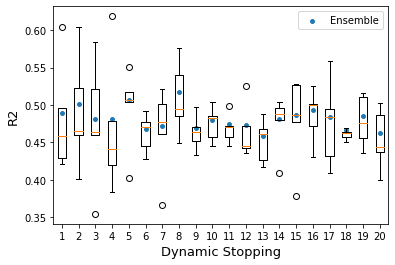

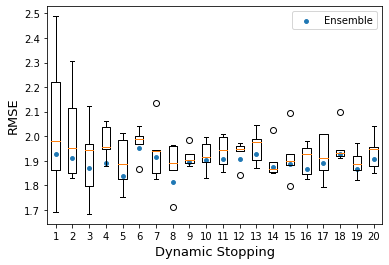

In [9]:
#step 2 -- Generating the Supplemental Figure
for thing in ['R2','RMSE']:
    xs=list(range(1,21))
    toplot=[]
    for x in xs:
        toplot.append(data[x][thing])
    
    counter=1
    xs2=[]
    for item in toplot:
        xs2.append([counter,counter,counter,counter,counter])
        counter+=1
    
    ens_toplot=[]
    for x in xs:
        ens_toplot.append(data[x]['ens'+thing])
    
    fig=plt.figure()
    plt.boxplot(toplot)
    plt.scatter(xs,ens_toplot,s=15,label='Ensemble')
    #plt.scatter(xs2,toplot,s=10,label='Individual',color='green')
    plt.legend()
    plt.ylabel(thing)
    plt.xlabel('Dynamic Stopping')
    plt.rc('axes',labelsize=13)
    plt.rc('axes',titlesize=13)
    plt.savefig(f'figures/final_model_ind_dyn_{thing}.pdf')

In [10]:
#determining the min Average RMSE
mRMSE=99999999
mdyn=0
for dyn in data:
    ave=np.mean(data[dyn]['RMSE'])
    if ave < mRMSE:
        mRMSE=ave
        mdyn=dyn
print(mRMSE,mdyn)

1.8778042721844361 8


In [11]:
#step 3 -- Generating the mean and standard deviation of the deployed model on the independent test set
predfiles=glob.glob("data/predictions/final_model_ind_dyn8_*.predictions")
bestRMSEmodel=""
bestR2model=""
bRMSE=99999
bR2=-1
rmses=[]
r2s=[]
for f in predfiles:
    tmp=pd.read_csv(f)
    preds.append(tmp['pred'].to_list())
    g=np.array(tmp['true'].to_list())
    p=np.array(tmp['pred'].to_list())
    ccvRMSE,ccvR2=get_stats(g,p)
    rmses.append(ccvRMSE)
    r2s.append(ccvR2)
    if ccvRMSE < bRMSE:
        bRMSE=ccvRMSE
        bestRMSEmodel=f
    if ccvR2 > bR2:
        bR2=ccvR2
        bestR2model=f
print(bRMSE,bestRMSEmodel)
print(bR2,bestR2model)

1.710710001150879 data/predictions/final_model_ind_dyn8_s3.predictions
0.5768538649308053 data/predictions/final_model_ind_dyn8_s3.predictions


In [12]:
print(np.mean(rmses),np.std(rmses))
print(np.mean(r2s),np.std(r2s))

1.8778042721844361 0.09250513883450179
0.5091304692377083 0.04449225019642136


In [13]:
data[8]

{'R2': [0.48587103661398673,
  0.5395078064304927,
  0.494589388378514,
  0.5768538649308053,
  0.4488302498347425],
 'RMSE': [1.8618233762985488,
  1.9648817263389258,
  1.8910191117034012,
  1.710710001150879,
  1.9605871454304256],
 'ensR2': 0.5174486206148375,
 'ensRMSE': 1.8137960146982184}

In [14]:
#step 4 -- Generating the data for the training set
todo=glob.glob('data/training_data/final_model/*dyn8*testdic.pi')
rmses=[]
r2s=[]
for fname in todo:
    dic=pickle.load(open(fname,'rb'))
    rmses.append(dic['RMSE'])
    r2s.append(dic['R2'])
    if 'seed3' in fname:
        print(dic['RMSE'],dic['R2'])

1.14423482786716 0.7766111073887221


In [15]:
print(np.mean(rmses),np.std(rmses))
print(np.mean(r2s),np.std(r2s))

1.170649141893826 0.05043465715814216
0.7843932174479028 0.0064311381188713055


In [16]:
#step 5 -- Generating the data for the Ensemble on the Training set
todo=glob.glob('data/training_data/final_model/ind*.predictions')
preds=[]
    
for f in todo:
    tmp=pd.read_csv(f)
    preds.append(tmp['pred'].to_list())
    g=np.array(tmp['true'].to_list())
    p=np.array(tmp['pred'].to_list())
    #ccvRMSE,ccvR2=get_stats(g,p)
    #data[dyn]['R2'].append(ccvR2)
    #data[dyn]['RMSE'].append(ccvRMSE)

ensemble_preds=np.array([np.mean([a,b,c,d,e]) for a,b,c,d,e in zip(*preds)])
ensRMSE,ensR2=get_stats(g,ensemble_preds)
print(ensRMSE,ensR2)

1.0676152969384596 0.7983174792699118


## Generating the figures for 2D vs 3D embeddings of the molecule

In [17]:
# need 2D vs 3D plots & t-test for significance for the first 10 models.
def plotter(xlabel,ylabel,hue,dataframe,savename):
    fig=plt.figure()
    sns.boxplot(xlabel,ylabel,data=dataframe,color='w')
    a=sns.swarmplot(xlabel,ylabel,hue=hue,data=df)
    plt.legend(bbox_to_anchor=(1.05,1),loc=2)
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig(savename)

In [18]:
df=pd.read_csv('data/model_selection.csv')

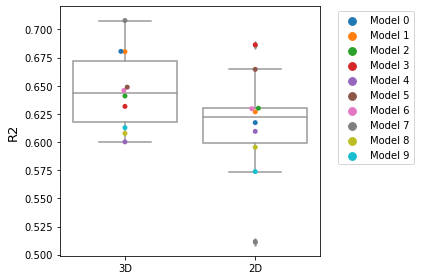

In [19]:
plotter('Conformer Dimension','R2','model',df,'figures/2dv3d_r2.pdf')

In [20]:
#T-Test for the above plot
ttest_ind(df[df['Conformer Dimension']=='2D']['R2'],df[df['Conformer Dimension']=='3D']['R2'])

Ttest_indResult(statistic=-1.6514130654734087, pvalue=0.11599231168237253)

In [21]:
np.mean(df[df['Conformer Dimension']=='2D']['R2']), np.mean(df[df['Conformer Dimension']=='3D']['R2'])

(0.6144788299970487, 0.6456377198756293)

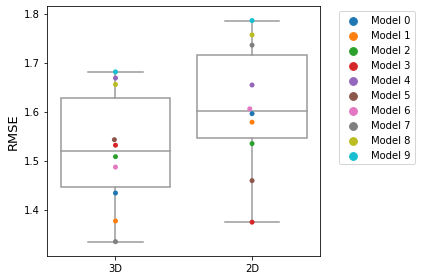

In [22]:
plotter('Conformer Dimension','RMSE','model',df,'figures/2dv3d_rmse.pdf')

In [23]:
#T-Test for the above plot
ttest_ind(df[df['Conformer Dimension']=='2D']['RMSE'],df[df['Conformer Dimension']=='3D']['RMSE'])

Ttest_indResult(statistic=1.528668871470288, pvalue=0.14372944251741623)

In [24]:
np.mean(df[df['Conformer Dimension']=='2D']['RMSE']), np.mean(df[df['Conformer Dimension']=='3D']['RMSE'])

(1.6080328292596349, 1.5219235692578992)

## Generating the figures for Fragmenting Salt analysis

In [25]:
basedirs=['final_model_full_saltfragafter','final_model_noothers_saltfragafter','final_model_others2plus_saltfragafter','final_model_othersMW_saltfragafter']
saltfrag_data={}
for d in basedirs:
    saltfrag_data[d]={}
    for thing in ['train_test','trainsalt_test','train_testsalt','trainsalt_testsalt']:
        saltfrag_data[d][thing]={'RMSEs':[],'R2s':[]}
        for seed in ['0','1','2','3','4']:
            preds=np.array([])
            golds=np.array([])

            #we are working with full ccv for training to predict the removed test set
            predfiles=glob.glob(f'data/predictions/{d}/*{thing}_s{seed}f*.predictions')
            for f in predfiles:
                tmp=pd.read_csv(f)
                g=np.array(tmp['true'].to_list())
                p=np.array(tmp['pred'].to_list())
                golds=np.append(golds,g)
                preds=np.append(preds,p)
            #now that we have the full preds and golds arrays we can calculate the R2 and RMSE
            ccvRMSE,ccvR2=get_stats(preds,golds)
            saltfrag_data[d][thing]['RMSEs'].append(ccvRMSE)
            saltfrag_data[d][thing]['R2s'].append(ccvR2) 

Full AqSol Data R2s Ttest_indResult(statistic=2.1934859709055674, pvalue=0.059596186794829656)
Full AqSol Data R2s Ttest_indResult(statistic=-1.4496020124670712, pvalue=0.1852121098547752)
Full AqSol Data RMSEs Ttest_indResult(statistic=0.39843371673204203, pvalue=0.7007329710106283)
Full AqSol Data RMSEs Ttest_indResult(statistic=1.0367278229758814, pvalue=0.3301805727392053)
AqSol Without Other typed molecules R2s Ttest_indResult(statistic=1.5682761197747412, pvalue=0.15545399812278501)
AqSol Without Other typed molecules R2s Ttest_indResult(statistic=-3.2559355988055563, pvalue=0.011597594438226016)
AqSol Without Other typed molecules RMSEs Ttest_indResult(statistic=-0.945887667575338, pvalue=0.371895084315655)
AqSol Without Other typed molecules RMSEs Ttest_indResult(statistic=1.9676839728315874, pvalue=0.08464632784846401)
AqSol Without 1 atom Other typed molecules R2s Ttest_indResult(statistic=2.7779296914994833, pvalue=0.02400111699633856)
AqSol Without 1 atom Other typed molecu

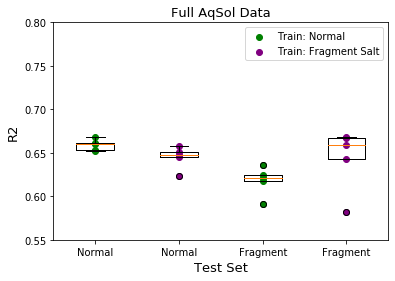

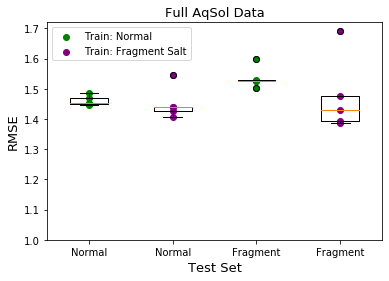

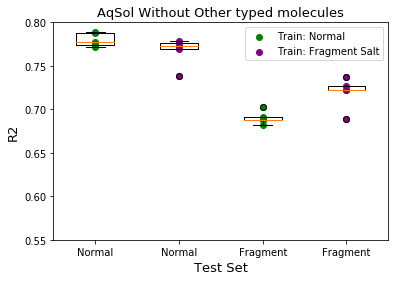

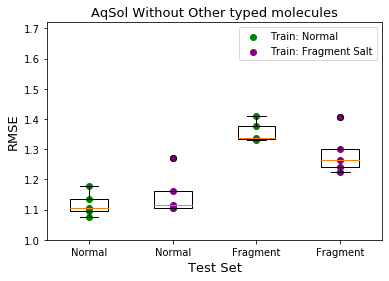

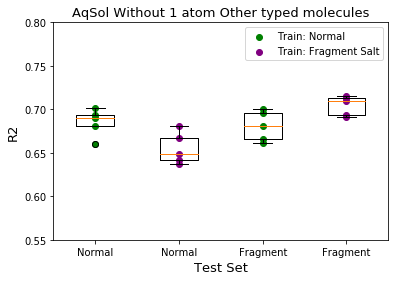

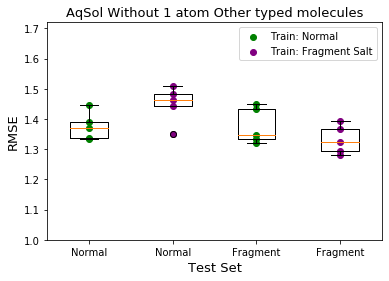

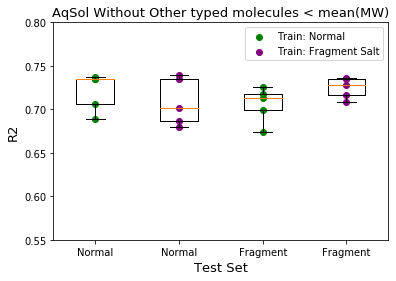

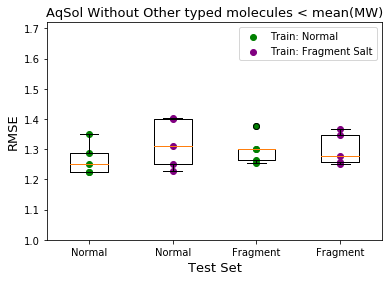

In [26]:
lookup_titles={
    'final_model_full_saltfragafter':'Full AqSol Data',
    'final_model_noothers_saltfragafter':'AqSol Without Other typed molecules',
    'final_model_others2plus_saltfragafter':'AqSol Without 1 atom Other typed molecules',
    'final_model_othersMW_saltfragafter':'AqSol Without Other typed molecules < mean(MW)'
}

color_lookup={0:'purple',1:'green'}
label_lookup={
    0:'Train: Fragment Salt',
    1:'Train: Normal',
}
for d in basedirs:
    for thing in ['R2s','RMSEs']:
        fig,ax=plt.subplots()
        toplot=[]
        labels=['train_test','trainSF_test','train_testSF','trainSF_testSF']
        for x in labels:
            toplot.append(saltfrag_data[d][x.replace('SF','salt')][thing])
        ax.boxplot(toplot)
        
        x=1
        for item in [[toplot[0],toplot[2]],[toplot[1],toplot[3]]]:
            ax.scatter([[x,x,x,x,x],[x+2,x+2,x+2,x+2,x+2]],item,label=label_lookup[x%2],color=color_lookup[x%2])
            x+=1
        #plt.scatter([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4]],toplot,label=['Train: Salts','Train: Fragmented Salt','Train: Salts','Train: Fragmented Salt'],color=plot_colors)
        plt.xticks([1,2,3,4],['Normal','Normal','Fragment','Fragment'])
        plt.title(lookup_titles[d])
        if thing=='RMSEs':
            plt.ylim((1.0,1.72))
        else:
            plt.ylim((0.55,0.80))
        plt.ylabel(thing.replace('s',''))
        plt.legend()
        plt.xlabel('Test Set')
        plt.savefig(f'figures/{d.split("_")[-2]}_saltfragfirst_{thing}_boxplots.pdf')
        
        print(f'{lookup_titles[d]} {thing} {ttest_ind(toplot[0],toplot[1])}')
        print(f'{lookup_titles[d]} {thing} {ttest_ind(toplot[2],toplot[3])}')

## Generating the timing analysis here

### This is for the initial version of SolTranNet -- i.e. the version that we used in our sweeps.
### Note: This code will take a fair amount of time to run

In [28]:
os.chdir('src')
from data_utils import load_data_from_df as load_df_gpu
from data_utils import construct_loader as construct_loader_gpu
from data_utils import load_data_from_smiles as load_smiles_gpu

from cpu_data_utils import load_data_from_df as load_df_cpu
from cpu_data_utils import construct_loader as construct_loader_cpu
from cpu_data_utils import load_data_from_smiles as load_smiles_cpu

from transformer import make_model
import time

In [29]:
def complex_measure(model,list_of_smiles,two_d=False,model_cpu=False,batch_size=1):
    '''
    A more complicated measure of the forward-pass.
    
    This function takes in a list of smile strings, then will create the needed molecular graphs & run the forward-pass
    
    Assumes the model is in evaluate mode
    '''
    t0=time.time()
    ls=[0.0 for x in list_of_smiles]
    t1=time.time()
    if model_cpu:
        X,y=load_smiles_cpu(list_of_smiles,ls,add_dummy_node=True,one_hot_formal_charge=True,two_d_only=two_d)
    else:
        X,y=load_smiles_gpu(list_of_smiles,ls,add_dummy_node=True,one_hot_formal_charge=True,two_d_only=two_d)
    tload=time.time()-t1
    if model_cpu:
        data_loader=construct_loader_cpu(X,y,batch_size)
    else:
        data_loader=construct_loader_gpu(X,y,batch_size)
    for batch in data_loader:
        adjacency_matrix, node_features, distance_matrix, y = batch
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        y_pred = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
    elapsed_fp=time.time()-t0
    return elapsed_fp,tload

In [30]:
#making the original MAT implementation -- GPU
d_atom=28
mat_model_params = {
    'd_atom': d_atom,
    'd_model': 1024,
    'N': 8,
    'h': 16,
    'N_dense': 1,
    'lambda_attention': 0.33, 
    'lambda_distance': 0.33,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.0,
    'aggregation_type': 'mean'
}

In [31]:
mat_gpu=make_model(**mat_model_params)

mat_gpu.to('cuda')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [34]:
smis=open('../data/llinas2020/llinas2020_raw.csv').readlines()
smis=[x.split(',')[-1].rstrip() for x in smis[1:]]

In [37]:
for size in [1,8,16,32,64]:
    print('---------------',size,'-----------------')
    mgpu_2d=[]
    mgpu_3d=[]
    for run in range(10):
        mat_gpu_times_2d=[]
        mat_gpu_times_3d=[]
        mat_gpu_times_2d.append(complex_measure(mat_gpu,smis,two_d=True,batch_size=size))
        mat_gpu_times_3d.append(complex_measure(mat_gpu,smis,two_d=False,batch_size=size))
        mgpu_2d.append(np.mean([x[0] for x in mat_gpu_times_2d]))
        mgpu_3d.append(np.mean([x[0] for x in mat_gpu_times_3d]))
        
    print(f'MAT GPU - 2D {np.mean(mgpu_2d)/len(smis)}  {np.std(mgpu_2d)/len(smis)}')
    print(f'MAT GPU - 3D {np.mean(mgpu_3d)/len(smis)}  {np.std(mgpu_3d)/len(smis)}')

--------------- 1 -----------------
MAT GPU - 2D 0.021030796838529184  0.0006150383786503566
MAT GPU - 3D 0.14457468878139149  0.003034750850102478
--------------- 8 -----------------
MAT GPU - 2D 0.004644437992211544  4.477712879492095e-05
MAT GPU - 3D 0.12646850510077043  0.004810894287332894
--------------- 16 -----------------
MAT GPU - 2D 0.0036604070302211876  4.488038635910208e-05
MAT GPU - 3D 0.12516471273971327  0.0017830054983316507
--------------- 32 -----------------
MAT GPU - 2D 0.003483802080154419  0.00013084201113937183
MAT GPU - 3D 0.12759385813366284  0.00600500746198522
--------------- 64 -----------------
MAT GPU - 2D 0.0038301247538942277  9.29755942377797e-05
MAT GPU - 3D 0.12579218420115384  0.003708472863576227


In [38]:
#doing the same analysis as above, but on CPU
mat_cpu=make_model(**mat_model_params)
mat_cpu.to('cpu')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [39]:
for size in [1,8,16,32,64]:
    print('---------------',size,'-----------------')
    mcpu_2d=[]
    mcpu_3d=[]
    for run in range(10):
        mat_cpu_times_2d=[]
        mat_cpu_times_3d=[]
        mat_cpu_times_2d.append(complex_measure(mat_cpu,smis,two_d=True,model_cpu=True,batch_size=size))
        mat_cpu_times_3d.append(complex_measure(mat_cpu,smis,two_d=False,model_cpu=True,batch_size=size))
        mcpu_2d.append(np.mean([x[0] for x in mat_cpu_times_2d]))
        mcpu_3d.append(np.mean([x[0] for x in mat_cpu_times_3d]))
    print(f'MAT CPU - 2D {np.mean(mcpu_2d)/len(smis)}  {np.std(mcpu_2d)/len(smis)}')
    print(f'MAT CPU - 3D {np.mean(mcpu_3d)/len(smis)}  {np.std(mcpu_3d)/len(smis)}')

--------------- 1 -----------------
MAT CPU - 2D 0.03870748136982773  0.0002540162402961693
MAT CPU - 3D 0.16035449811906527  0.0029694794775658893
--------------- 8 -----------------
MAT CPU - 2D 0.023654645681381228  0.001207345628239431
MAT CPU - 3D 0.14568089102253767  0.0037442121353101253
--------------- 16 -----------------
MAT CPU - 2D 0.02506009087418065  0.0015835453232911304
MAT CPU - 3D 0.14760175690506444  0.003217568372115887
--------------- 32 -----------------
MAT CPU - 2D 0.028485690644293123  0.0024546811395427287
MAT CPU - 3D 0.15021801753477618  0.003455153942147226
--------------- 64 -----------------
MAT CPU - 2D 0.03436281988115021  0.004738437151056888
MAT CPU - 3D 0.15709714257355895  0.004007531437141321


In [40]:
os.chdir('..')

## Now for the deployed version of SolTranNet

### Note that this version is only 2D, and automatically detects and uses a GPU if available.

In [27]:
#doing the analysis as above but with the deployed verion.
# 
#NOTE: This was performed utilizing the soltrannet_benchmark.py script running from the optim_src directory!

#I used the following commands (from within that directory) to generate the files (given times are in seconds)

In [28]:
#python3 soltrannet_benchmark.py -i test --permolecule > stn_batches_gpu_time.out
!cat optim_src/stn_batches_gpu_time.out

--------------- Batch Size: 1  -----------------
STN  time:0.019889647310430355  std:0.000755387041715959
--------------- Batch Size: 8  -----------------
STN  time:0.0037280265128973758  std:0.00011798365463399014
--------------- Batch Size: 16  -----------------
STN  time:0.002674855427308516  std:5.14802136143816e-05
--------------- Batch Size: 32  -----------------
STN  time:0.0022253509723778927  std:4.145642538265789e-05
--------------- Batch Size: 64  -----------------
STN  time:0.002109179532889164  std:8.390332973168637e-05


In [29]:
#python3 soltrannet_benchmark.py -i test --permolecule --cpu > stn_batches_cpu_time.out
!cat optim_src/stn_batches_cpu_time.out

--------------- Batch Size: 1  -----------------
STN  time:0.01518600005092043  std:0.0009849858998327557
--------------- Batch Size: 8  -----------------
STN  time:0.0038277225060896437  std:0.00035211870892168454
--------------- Batch Size: 16  -----------------
STN  time:0.003113202253977458  std:0.000276535176248518
--------------- Batch Size: 32  -----------------
STN  time:0.002827778548905344  std:9.01450800872483e-05
--------------- Batch Size: 64  -----------------
STN  time:0.0029501436334667783  std:0.00017619582186137415


In [30]:
#python3 soltrannet_benchmark.py -i test1million.gz --batchsize 32 --numruns 1 > 1million_time.out
!cat optim_src/1million_time.out

--------------- Batch Size: 32  -----------------
STN  time 2161.3525054454803  std:0.00


## Generating the Latex for the performance on multiple test sets

In [40]:
#calculating the means and standard deviations for the table
def helper(filename):
    tmp=pickle.load(open(filename,'rb'))
    return tmp['R2'],tmp['RMSE']

def helper2(filename):
    tmp=pd.read_csv(filename)
    gold=np.array(tmp['true'].to_list())
    pred=np.array(tmp['pred'].to_list())
    ccvRMSE,ccvR2=get_stats(gold,pred)
    return ccvR2, ccvRMSE

#Cui et all 2020
todo=glob.glob('data/cui2020/*testdic.pi')
r2s=[]
rmses=[]
for fname in todo:
    r2,rmse=helper(fname)
    r2s.append(r2)
    rmses.append(rmse)
print(f'Cui2020 Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')
print(f'Cui2020 Best R2:{np.max(r2s)}   RMSE:{np.min(rmses)}')
print(f'Cui2020 Deployed: {helper2("data/cui2020/final_aq_model.predictions")}')
print('----------------------------------------')

#Boobier et al 2017
todo=glob.glob('data/boobier2017/*testdic.pi')

r2s=[]
rmses=[]
for fname in [x for x in todo if '_2d_' not in x]:
    r2,rmse=helper(fname)
    r2s.append(r2)
    rmses.append(rmse)
print(f'Boobier2017 R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')
print(f'Boobier2017 Best R2:{np.max(r2s)}   RMSE:{np.min(rmses)}')
print(f'Boobier2017 Deployed: {helper2("data/boobier2017/final_aq_model.predictions")}')
print('----------------------------------------')

#Louvric et al 2020
for key in ['seed*1000epochs','final_aq_model']:
    todo=glob.glob('data/louvric2020/'+key+'*.predictions')
    r2s=[]
    rmses=[]
    for fname in todo:
        r2,rmse=helper2(fname)
        r2s.append(r2)
        rmses.append(rmse)
    print(f'Louvric2020 Training {key} Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')
    print(f'Louvric2020 {key} Best R2:{np.max(r2s)}   RMSE:{np.min(rmses)}')
print('----------------------------------------')
#LLinas et al 2020
for key in ['llinas_set1','llinas_set2']:
    todo=glob.glob(f'data/llinas2020/soltrannet/{key}*testdic.pi')
    r2s=[]
    rmses=[]
    for fname in todo:
        r2,rmse=helper(fname)
        r2s.append(r2)
        rmses.append(rmse)
    print(f'LLinas2020 {key} Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')
    print(f'LLinas2020 {key} Training Best R2:{np.max(r2s)}   RMSE:{np.min(rmses)}')
    print(f'Llinas2020 {key} Deployed: {helper2(f"data/llinas2020/soltrannet/{key}_final_aq_model.predictions")}')

Cui2020 Training R2:0.5886204221886455,0.024413513767568156  RMSE:0.8600285893941907,0.21482372703860816
Cui2020 Best R2:0.6113130081035003   RMSE:0.6241022870681117
Cui2020 Deployed: (0.6563802388698684, 0.8127053399347246)
----------------------------------------
Boobier2017 R2:0.5432285946421288,0.1424843888425703  RMSE:1.2739101709030884,0.1775665240747097
Boobier2017 Best R2:0.7241077367030688   RMSE:1.010038294428349
Boobier2017 Deployed: (0.7728606218442503, 0.8453452132656011)
----------------------------------------
Louvric2020 Training seed*1000epochs Training R2:0.709438949167738,0.05365680996818616  RMSE:0.8979027406547612,0.10091079505030429
Louvric2020 seed*1000epochs Best R2:0.7830056219910293   RMSE:0.720145631344509
Louvric2020 Training final_aq_model Training R2:0.7443717125492011,0.03452115943712588  RMSE:0.853905298269586,0.06719889461724718
Louvric2020 final_aq_model Best R2:0.7942262979370159   RMSE:0.7334127415387698
----------------------------------------
LLina

In [41]:
def count_overlap(list_o_smiles):
    '''
    counts the number of identical molecules in list_o_smiles to AqSolDB
    '''
    
    aqsol_smiles=pd.read_csv('data/training_data/aqsol_2d.csv')['smiles'].tolist()
    aqsol_fps=[Chem.RDKFingerprint(Chem.MolFromSmiles(x)) for x in aqsol_smiles]
    
    input_fps=[Chem.RDKFingerprint(Chem.MolFromSmiles(x)) for x in list_o_smiles]
    
    counter=0
    for fp1 in input_fps:
        for fp2 in aqsol_fps:
            if DataStructs.FingerprintSimilarity(fp1, fp2)==1:
                counter+=1
                break
    return counter

In [42]:
#Cui2020 overlap
cui_smis=pd.read_csv('data/cui2020/cui_et_all_sol_2d_testing.csv')['smiles'].tolist()
print(f'Cui Overlap: {count_overlap(cui_smis)}/{len(cui_smis)}')

RDKit WARNING: [15:54:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:14] WARNING: not r

Cui Overlap: 0/62


In [43]:
#boobier2017 overlap
boob_smis=pd.read_csv('data/boobier2017/dls100_test.csv')['smiles'].tolist()
print(f'Boobier Overlap: {count_overlap(boob_smis)}/{len(boob_smis)}')

RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:22] WARNING: not r

Boobier Overlap: 23/25


In [44]:
#louvric2020 overlap
todo=glob.glob('data/louvric2020/louvric2020_*_test.csv')
overlaps=[]
for fname in todo:
    lov_smis=pd.read_csv(fname)['smiles'].tolist()
    overlaps.append(count_overlap(lov_smis))
    print(f'Lovric Overlap: {count_overlap(lov_smis)}/{len(lov_smis)}')
print(np.mean(overlaps))

RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:27] WARNING: not r

RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:37] WARNING: not r

Lovric Overlap: 155/166


RDKit WARNING: [15:54:44] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:44] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:44] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:44] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:44] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:45] WARNING: not r

RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:54:54] WARNING: not r

Lovric Overlap: 149/166


RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:02] WARNING: not r

RDKit WARNING: [15:55:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:12] WARNING: not r

Lovric Overlap: 148/166


RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:20] WARNING: not r

RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:29] WARNING: not r

Lovric Overlap: 156/166


RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:37] WARNING: not r

RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:47] WARNING: not r

Lovric Overlap: 149/166
151.4


In [45]:
#llinas2020 overlap
todo=glob.glob('data/llinas2020/llinas2020*test.csv')
for fname in todo:
    ll_smis=pd.read_csv(fname)['smiles'].tolist()
    print(f'llinas Overlap: {count_overlap(ll_smis)}/{len(ll_smis)}')

RDKit WARNING: [15:55:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:55:55] WARNING: not r

llinas Overlap: 79/100


RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:03] WARNING: not r

llinas Overlap: 18/32


In [46]:
data=pd.read_csv('data/soltrannet_othersets.csv')
data.columns

Index(['Dataset', 'Reported R2', 'Reported RMSE', 'SolTranNet Training R2',
       'SolTranNet Best R2', 'SolTranNet Deployed R2',
       'SolTranNet Training RMSE', 'SolTranNet Best RMSE',
       'SolTranNet Deployed RMSE', 'Deployed Training Overlap'],
      dtype='object')

In [47]:
print(data.to_latex(columns=['Dataset']+[x for x in data.columns.tolist() if 'RMSE' in x]+['Deployed Training Overlap']))

\begin{tabular}{llrlrll}
\toprule
{} &                 Dataset &  Reported RMSE & SolTranNet Training RMSE &  SolTranNet Best RMSE & SolTranNet Deployed RMSE & Deployed Training Overlap \\
\midrule
0 &          Cui et al 2020 &          0.681 &             0.860(0.215) &                 0.624 &                    0.813 &                      0/62 \\
1 &      Boobier et al 2017 &          0.985 &             1.274(0.178) &                 1.010 &                    0.845 &                     23/25 \\
2 &      Louvric et al 2020 &          0.720 &             0.898(0.101) &                 0.720 &            0.854(0.0672) &          151.4(3.382)/166 \\
3 &  Llinas et al 2020 set1 &          0.780 &             1.119(0.163) &                 0.952 &                    1.004 &                    79/100 \\
4 &  LLinas et al 2020 set2 &          1.060 &             1.811(0.328) &                 1.243 &                    1.295 &                     18/32 \\
\bottomrule
\end{tabular}



In [48]:
print(data.to_latex(columns=['Dataset']+[x for x in data.columns.tolist() if 'R2' in x]+['Deployed Training Overlap']))

\begin{tabular}{llllrll}
\toprule
{} &                 Dataset & Reported R2 & SolTranNet Training R2 &  SolTranNet Best R2 & SolTranNet Deployed R2 & Deployed Training Overlap \\
\midrule
0 &          Cui et al 2020 &       0.412 &          0.589(0.0244) &               0.611 &                  0.656 &                      0/62 \\
1 &      Boobier et al 2017 &       0.706 &           0.543(0.142) &               0.724 &                  0.773 &                     23/25 \\
2 &      Louvric et al 2020 &          -- &          0.709(0.0537) &               0.783 &          0.744(0.0345) &          151.4(3.382)/166 \\
3 &  Llinas et al 2020 set1 &        0.62 &          0.496(0.0268) &               0.527 &                  0.514 &                    79/100 \\
4 &  LLinas et al 2020 set2 &        0.75 &          0.769(0.0346) &               0.824 &                  0.726 &                     18/32 \\
\bottomrule
\end{tabular}



## Generating the plots for Classification on Second Challenge to Predict Aqueous Solubility

In [49]:
def calc_stats(pred_array, true_array, insol_thresh=-6, sol_thresh=-4):
    '''
    This function will calculate the following on the predicted array:
        Hit% = #correct(lower_sol_thresh,upper_sol_thresh) / #(lower_sol_thresh,upper_sol_thresh)
        Fail% = #true(insol_thresh)pred(lower_sol_thresh,upper_sol_thresh) / #pred(lower_sol_thresh,upper_sol_thresh)
    
    Assumptions: pred_array,true_array are paired numpy arrays.
    '''
    
    #first we need to access the examples which have true in (lower_sol_thresh, upper_sol_thresh)
    true_mask=(true_array > sol_thresh)
    
    #calculating the Hit%
    num_true=len(true_array[true_mask])
    poss_hits=pred_array[true_mask]
    num_hits=np.sum((poss_hits>sol_thresh))
    hit=num_hits/float(num_true)
    
    #calculating the Fail%
    pred_mask=(pred_array > sol_thresh)
    insol_mask=true_array <= insol_thresh
    fail=np.sum(insol_mask & pred_mask) / float(np.sum(pred_mask))
    
    return hit,fail,np.sum(true_mask),np.sum(pred_mask)

In [50]:
data={}

#adding the SolTranNet data
truths=np.array([])
preds=np.array([])
for s in ['set1','set2']:
    tmp=pd.read_csv(f'data/llinas2020/soltrannet/llinas_{s}_final_aq_model.predictions')
    t=tmp['true']
    truths=np.append(truths,t)
    p=tmp['pred']
    preds=np.append(preds,p)

for ins in [-4,-5,-6]:
    data[ins]={'hit':[],'fail':[]}
    hit,fail,nt,npred=calc_stats(preds,truths,ins,-4)
    data[ins]['hit']=[('SolTranNet',hit)]
    data[ins]['fail']=[('SolTranNet',fail)]

In [51]:
np.mean(truths)

-4.321439393939395

19


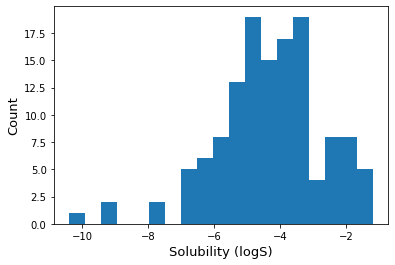

In [52]:
w=0.5
n=math.ceil((max(truths)-min(truths))/w)
print(n)
plt.hist(truths,bins=n)
plt.xlabel('Solubility (logS)')
plt.ylabel('Count')
plt.savefig('figures/histogram_solchal2_true_logs.pdf')

In [53]:
np.sum((truths>-6) & (truths <=-4)),len(truths)

(58, 132)

In [54]:
np.sum((truths>-5) & (truths <=-4)),len(truths)

(35, 132)

In [55]:
all_files=glob.glob('data/llinas2020/submitted/*.csv')
keys=set([x.split('/')[-1].split('_set')[0] for x in all_files])
for ins in [-4,-5,-6]:
    for k in keys:
        truths=np.array([])
        preds=np.array([])
        todo=glob.glob(f'data/llinas2020/submitted/{k}*.csv')
        for fname in todo:
            tmp=pd.read_csv(fname)
            t=tmp['TRUE']
            truths=np.append(truths,t)
            p=tmp['PREDICTED']
            preds=np.append(preds,p)
        hit,fail,nt,npred=calc_stats(preds,truths,ins,-4)
        if np.isnan(hit):
            print(f'{k} hit is nan')
        else:
            data[ins]['hit'].append((k,hit))

        if np.isnan(fail):
            print(f'{k} fail is nan')
        else:
            data[ins]['fail'].append((k,fail))

In [56]:
data

{-4: {'hit': [('SolTranNet', 0.9482758620689655),
   ('hpsu_b', 0.5517241379310345),
   ('asll_c', 0.9827586206896551),
   ('hpsu_a', 0.5517241379310345),
   ('xwuc_b', 0.896551724137931),
   ('mlkc_c', 0.8793103448275862),
   ('jhunc_b', 1.0),
   ('ytacu', 0.7586206896551724),
   ('jmsa_a', 0.9655172413793104),
   ('yumpu_a', 0.7931034482758621),
   ('mlkc_b', 0.896551724137931),
   ('mcsmd', 0.896551724137931),
   ('asll_b', 0.9137931034482759),
   ('flwmu', 0.9482758620689655),
   ('mlkc_a', 0.8620689655172413),
   ('jhunc_a', 0.9482758620689655),
   ('sgurv', 0.7931034482758621),
   ('jcsu_a', 0.8793103448275862),
   ('jhunc_c', 0.9827586206896551),
   ('asll_a', 1.0),
   ('pmsa_a', 0.7586206896551724),
   ('pmsa_c', 0.7758620689655172),
   ('nmupi', 0.8275862068965517),
   ('pmsa_b', 0.7413793103448276),
   ('rfsp_a', 0.9137931034482759),
   ('jhtny', 0.896551724137931),
   ('astu', 0.7413793103448276),
   ('umut_c', 0.896551724137931),
   ('jmsa_c', 0.9655172413793104),
   ('tdip

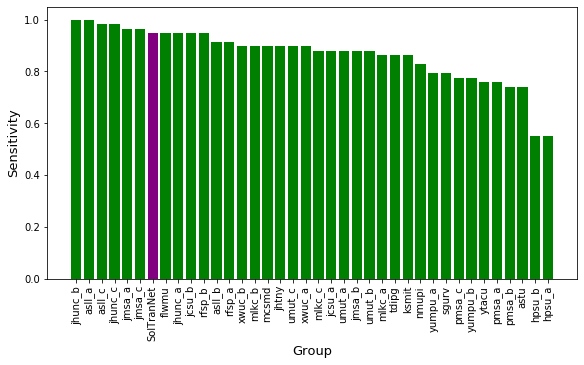

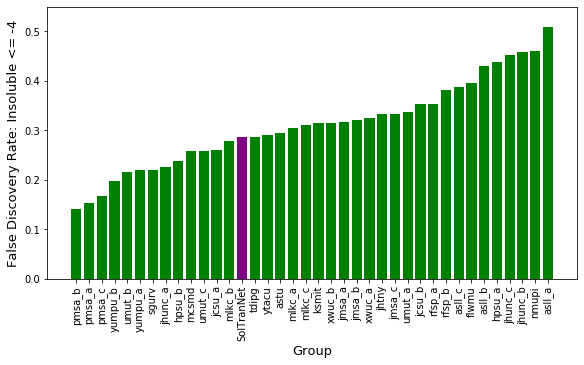

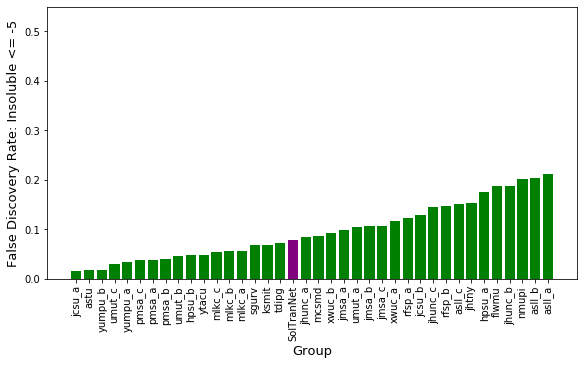

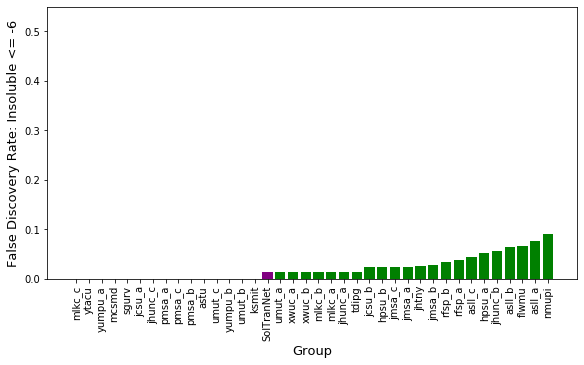

In [57]:
plotted_sens=False
for ins in data:
    for k in data[ins]:
        if k=='hit':
            if plotted_sens:
                continue
            fig=plt.figure(figsize=(9.5,5))
            all_data=sorted(data[ins][k],key=lambda x:x[1],reverse=True)
            plt.ylabel('Sensitivity')
        else:
            fig=plt.figure(figsize=(9.5,5))
            all_data=sorted(data[ins][k],key=lambda x:x[1])
            plt.ylabel(f'False Discovery Rate: Insoluble <= {ins}')
            plt.ylim((0,0.55))

        labels=[x[0] for x in all_data]
        ys=[x[1] for x in all_data]
        x_pos=[i for i,_ in enumerate(all_data)]
        colors=['purple' if x[0]=='SolTranNet' else 'green' for x in all_data]
        plt.bar(x_pos,ys,color=colors)
        plt.xlabel('Group')
        plt.xticks(x_pos,labels,rotation='vertical')
        plt.savefig(f'figures/{k}_{ins}_solchal2.pdf')
        plotted_sens=True

## Making Supplemental Figure 3

In [58]:
#Distribution of train/test solubilities for the scaffold split.
files=glob.glob('data/training_data/aqsol_scaf_2d_t*.csv')
sol_dic={'train':{},'test':{}}

for f in files:
    data=pd.read_csv(f)
    if '_train' in f:
        key1='train'
    else:
        key1='test'

    fold=f.split(key1)[-1][0]
    sol_dic[key1][fold]=data['y'].tolist()

61


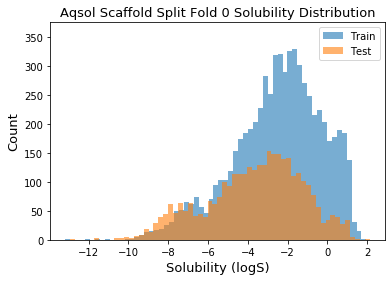

61


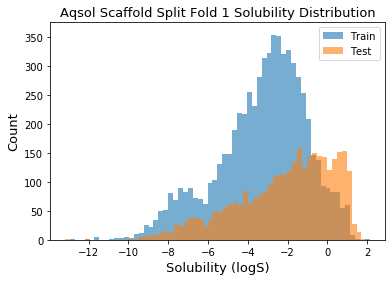

62


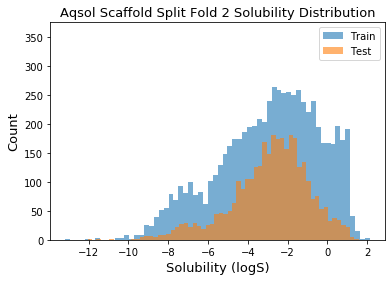

In [59]:
for fold in ['0','1','2']:
    w=0.25
    n=math.ceil((max(sol_dic['train'][fold])-min(sol_dic['train'][fold]))/w)
    print(n)
    plt.rc('axes',labelsize=13)
    plt.rc('axes',titlesize=13)
    plt.figure()
    plt.hist(sol_dic['train'][fold],label='Train',alpha=0.6,bins=n)
    plt.hist(sol_dic['test'][fold],label='Test',alpha=0.6,bins=n)
    plt.ylabel('Count')
    plt.xlabel('Solubility (logS)')
    plt.title('Aqsol Scaffold Split Fold '+fold+' Solubility Distribution')
    plt.ylim((0,375))
    plt.legend()
    plt.savefig('figures/aqsol_scaf'+fold+'_soldist.pdf')
    plt.show()

62
47


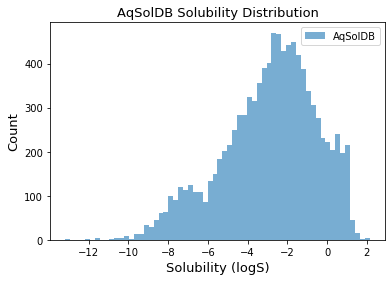

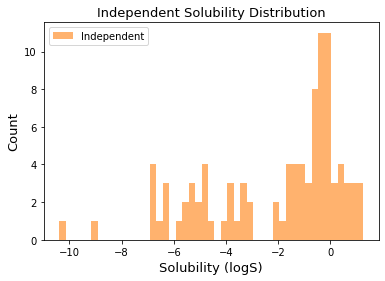

In [60]:
#doing the same for the full Aqsol set and our independent set
for fname in ['data/training_data/aqsol.csv','data/training_data/independent_sol.csv']:
    plt.figure()
    plt.rc('axes',labelsize=13)
    plt.rc('axes',titlesize=13)
    data=pd.read_csv(fname)
    if 'aqsol' in fname:
        l='AqSolDB'
        c='#1f77b4'
    else:
        l='Independent'
        c='#ff7f0e'
    w=0.25
    n=math.ceil((max(data['y'])-min(data['y']))/w)
    print(n)
    plt.hist(data['y'],label=l,color=c,alpha=0.6,bins=n)
    plt.legend()
    plt.ylabel('Count')
    plt.xlabel('Solubility (logS)')
    plt.title(f'{l} Solubility Distribution')
    plt.savefig(f'figures/{l}_solhist.pdf')